## Simple EDA

### Setup and import libs

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import math

import pandas as pd
import sqlalchemy
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)

from train import get_model_pipeline

### Load data

In [6]:
df = pd.read_csv('data/dataset.csv', parse_dates=['loan_date', 'acc_date'])
df.bad_payer.value_counts()

0    606
1     76
Name: bad_payer, dtype: int64

In [7]:
default_ratio = df.bad_payer.value_counts()[1]/len(df)
print('Default reatio:', default_ratio)

Default reatio: 0.11143695014662756


In [8]:
df.head()

,loan_id,loan_date,acc_date,loan_amount,loan_duration,acc_age,client_age,client_gender,district_name,district_region,district_inhabitants,district_avg_salary,bad_payer
0,4959,1994-01-05,1993-02-26,80952,24,28,76,M,Hl.m. Praha,Prague,1204953,12541,0
1,4961,1996-04-29,1995-04-07,30276,12,25,81,F,Tabor,south Bohemia,103347,9104,1
2,4962,1997-12-08,1996-07-28,30276,12,24,59,M,Frydek - Mistek,north Moravia,228848,9893,0
3,4967,1998-10-14,1997-08-18,318480,60,23,68,M,Strakonice,south Bohemia,70646,8547,1
4,4968,1998-04-19,1997-08-08,110736,48,23,81,F,Prachatice,south Bohemia,51428,8402,0


In [9]:
df.loan_date

0     1994-01-05
1     1996-04-29
2     1997-12-08
3     1998-10-14
4     1998-04-19
         ...    
677   1998-09-27
678   1998-07-18
679   1995-10-29
680   1996-08-06
681   1996-12-27
Name: loan_date, Length: 682, dtype: datetime64[ns]

In [10]:
list(df.loan_date)[0]

Timestamp('1994-01-05 00:00:00')

In [18]:
df.loan_date.dt.year + df.loan_date.dt.month

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U21'), dtype('<U21')) -> dtype('<U21')

In [6]:
df.dtypes

loan_id                  int64
loan_date               object
acc_date                object
loan_amount              int64
loan_duration            int64
acc_age                  int64
client_age               int64
client_gender           object
district_name           object
district_region         object
district_inhabitants     int64
district_avg_salary      int64
bad_payer                int64
dtype: object

In [7]:
df.describe(include = 'object')

,loan_date,acc_date,client_gender,district_name,district_region
count,682,682,682,682,682
unique,559,557,2,77,8
top,1998-04-19,1997-08-08,F,Hl.m. Praha,south Moravia
freq,4,4,348,84,129


In [8]:
df.describe()

,loan_id,loan_amount,loan_duration,acc_age,client_age,district_inhabitants,district_avg_salary,bad_payer
count,682.000000,682.000000,682.000000,682.000000,682.000000,6.820000e+02,682.000000,682.000000
mean,6172.466276,151410.175953,36.492669,25.024927,62.108504,2.720522e+05,9502.986804,0.111437
std,682.579279,113372.406310,17.075219,1.445321,12.659669,3.583320e+05,1323.150982,0.314903
min,4959.000000,4980.000000,12.000000,23.000000,40.000000,4.282100e+04,8110.000000,0.000000
25%,5577.500000,66732.000000,24.000000,24.000000,52.000000,9.208400e+04,8544.000000,0.000000
50%,6176.500000,116928.000000,36.000000,25.000000,62.000000,1.246050e+05,8991.000000,0.000000
75%,6752.500000,210654.000000,48.000000,26.000000,73.000000,2.261220e+05,9897.000000,0.000000
max,7308.000000,590820.000000,60.000000,28.000000,86.000000,1.204953e+06,12541.000000,1.000000


### Fit the model

In [9]:
CAT_COLS = ["client_gender", 'district_name', 'district_region']
NUM_COLS = ["loan_amount", "loan_duration", "acc_age", "client_age", "district_inhabitants", "district_avg_salary"]
TARGET = "bad_payer"

X = df[CAT_COLS + NUM_COLS]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, stratify=y, random_state=42)

pipeline = get_model_pipeline()
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('TargetEncoder',
                                                                   TargetEncoder())]),
                                                  ['client_gender',
                                                   'district_name',
                                                   'district_region']),
                                                 ('numeric',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'loan_duration', 

### Checking model performance

In [12]:
print("model accuracy: %.3f" % pipeline.score(X_test, y_test))

model accuracy: 0.888


Plotting the precision recall curve

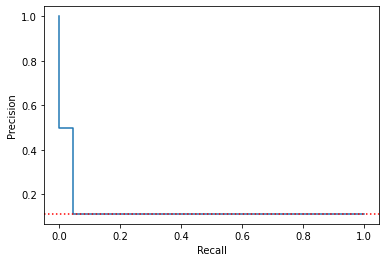

In [13]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.axhline(y=default_ratio, color='r', linestyle=':')

In [14]:
print(classification_report(y_test, y_pred, target_names=['good', 'bad']))

              precision    recall  f1-score   support

        good       0.89      0.99      0.94       182
         bad       0.50      0.04      0.08        23

    accuracy                           0.89       205
   macro avg       0.70      0.52      0.51       205
weighted avg       0.85      0.89      0.84       205



Model prediction probability distribution

<AxesSubplot:>

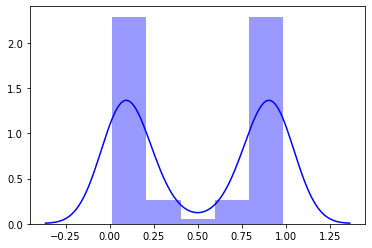

In [15]:
sns.distplot(pipeline.predict_proba(X_test), color='blue')

### Print the top 5 district and its respective variables (region, inhabitants and avg_salary)

In [16]:
df_group = df.groupby(['district_name', 'district_region', 'district_inhabitants', 'district_avg_salary'])['loan_id'].count()
df_group = df_group.reset_index()
df_group.sort_values(by=['loan_id'], inplace=True, ascending=False)
df_group

for index, row in df_group.head(5).iterrows():
    print(f'["{row["district_name"]}", "{row["district_region"]}", "{row["district_inhabitants"]}", "{row["district_avg_salary"]}"],')

["Hl.m. Praha", "Prague", "1204953", "12541"],
["Karvina", "north Moravia", "285387", "10177"],
["Brno - mesto", "south Moravia", "387570", "9897"],
["Ostrava - mesto", "north Moravia", "323870", "10673"],
["Zlin", "south Moravia", "197099", "9624"],
